## Name: Phuong Do
# Synthesis and Characterizations of CdSe Quantum Dots
##### In this project, my objective is to extract meaningful data from the UV-Vis and Fluorescence measurements to calculate the diameters of the synthesized CdSe quantum dots (QDs). Then, I study and generate two mathematical models for my experimental and reference data to gain insights into the relationship among UV absorbed wavelengths, reaction time, instantaneous temperature and its rising rate. Primary tasks include:
##### 1. Cleaning and extracting data from experimental files
##### 2. Filtering important data sets
##### 3. Calculating quantum dots' diameters based on two characterization approaches 
##### 4. Illustrating graphs for data comparisons
##### 5. Modeling the relationship between relevant parameters
##### 6. Conclusions and discussions
#### Experimental procedures and data collection in this project are part of a lab session for CHEM 347 - Concepts of Inorganic Chemistry with Lab (Department of Chemistry - Dickinson College)

## I. Function Definitions

In [648]:
# Import necessary libraries and modules
import matplotlib.pyplot as plt
import numpy as np
import glob
import scipy.constants as const
import math
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

In [650]:
def cleanAndExtractData (files, x, xPos, y, yPos, splitItem):
    """Extracts numerical data from multiple files with a shared portion in path to plot x vs. y graph 
        files (list): file paths list
        x (list): global variable to hold x data points from xPos index position
        y (list): global variable to hold y data points from yPos index position
        splitItem (str): delimiter/character that separates the the x and y data in each line of the file"""
    for file in files:
        ptX=[]
        ptY=[]
        with open(file, 'r') as file:
            for line in file:
                if line.strip() and line[0].isnumeric(): 
                    ptX.append(float(line.split(splitItem)[xPos].strip()))
                    ptY.append(float(line.split(splitItem)[yPos].strip()))
            x.append(ptX)
            y.append(ptY)

def linearFitAndPlot (xRange, yRange, startVal, endVal): 
    """Generates linear fitting plot for a specific startVal-endVal x range with given x-y data set
        xRange (list): full x data
        yRange (list): full y data
        startVal (int): starting x value to plot
        endVal (int): ending x value to plot
    x-intercept is returned specifically for the purpose of this project"""
    xPts = []
    yPts = []
    for x, y in zip(xRange, yRange):
        if x >= startVal and x <= endVal:
            xPts.append(x)
            yPts.append(y)
    pts = np.polyfit(xPts, yPts, 1) 
    fullXRange = np.linspace(min(xRange), max(xRange), 500)
    fittedY = pts[0] * fullXRange + pts[1]
    plt.plot(fullXRange, fittedY)
    plt.ylim(bottom=0)
    return  -(pts[1]/pts[0]) 

def UVabsorbanceQDsDiameter (m_e, m_h, corectF, Eb, wL):
    """Calculate diameters of quantum dots of any specific material based on Quantum confinement equation
        m_e (unitless): effective electron mass
        m_h (unitless): effective hole mass
        corectF: correction factor
        Eb (J): band-gap energy of bulk material
        wL (nm): absorbed UV wavelength of the QDs
    The roots of quadratic equation is returned as tuple, which contains both positive and negative root"""
    a = (pow(const.h, 2)/8)*((1/m_e)+(1/m_h))/(const.m_e)
    b = -1.8*pow(const.e,2)/(4*const.pi*const.epsilon_0*corectF)
    c = Eb - (const.h * const.c / (wL * 1e-9))
    d = np.roots([a, b, c])
    return d

def analyzeQDsMathModels(data, dataset_name):
    """Analyze linear and quadratic growth models for the given dataset.
         data (list): wavelength dataset.
         dataset_name (str): name of the dataset for labeling plots.
        This one is built specifically for the dataset in this project (referred to my note below for further explanation)"""
    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Generate features for models
    x1_data = [temp + (dTt * t) for temp, dTt, t in zip(data["T(C)"], data["dT/dt(C/min)"], data["t(min)"])]
    x2_data = [math.log(t / temp) for temp, t in zip(data["T(C)"], data["t(min)"])]
    y1_data = df["UV Emission (nm)"]
    y2_data = [1 / w for w in df["UV Emission (nm)"]]

    # Extract features and target
    X1 = np.array(x1_data).reshape(-1, 1)
    X2 = np.array(x2_data).reshape(-1, 1)
    Y1 = np.array(y1_data)
    Y2 = np.array(y2_data)

    # Model 1: Linear Fit 
    model1 = LinearRegression()
    model1.fit(X1, Y1)
    y1_pred = model1.predict(X1)
    r2_model1 = r2_score(Y1, y1_pred)

    # Model 2: Quadratic Fit
    poly2 = PolynomialFeatures(degree=2, include_bias=False)
    X2_poly = poly2.fit_transform(X2)
    model2 = LinearRegression()
    model2.fit(X2_poly, Y2)
    y2_pred = model2.predict(X2_poly)
    r2_model2 = r2_score(Y2, y2_pred)

    # Smoother data for quadratic fit
    X2_smooth = np.linspace(X2.min(), X2.max(), 100).reshape(-1, 1)
    X2_smooth_poly = poly2.transform(X2_smooth)
    y2_smooth = model2.predict(X2_smooth_poly)

    # Create labels for models
    linear_label = (f"Linear Fit: w = a(T + dT/dt * t) + b\nR² = {r2_model1:.4f}")
    quad_label = (f"Quadratic Fit: 1/w = a(ln(t/T))² + bln(t/T) + c\nR² = {r2_model2:.4f}")

    # Plot real data points and the linear fit
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(X1, Y1, color="blue", label="Experimental")
    plt.plot(X1, y1_pred, color="red", label=linear_label)
    plt.xlabel("T + dT/dt * t (C)")
    plt.ylabel("w (nm)")
    plt.title(f"{dataset_name} Model 1: Linear Fit", fontsize=11, fontweight="bold")
    plt.legend(fontsize=9)
    plt.grid(True)

    # Plot real data points and the quadratic fit
    plt.subplot(1, 2, 2)
    plt.scatter(X2, Y2, color="blue", label="Experimental")
    plt.plot(X2_smooth, y2_smooth, color="red", label=quad_label)
    plt.xlabel("ln(t/T)")
    plt.ylabel("1/w (1/nm)")
    plt.title(f"{dataset_name} Model 2: Quadratic Fit", fontsize=11, fontweight="bold")
    plt.legend(fontsize=9)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

## II. Fluorescence Spectra Plot

[]

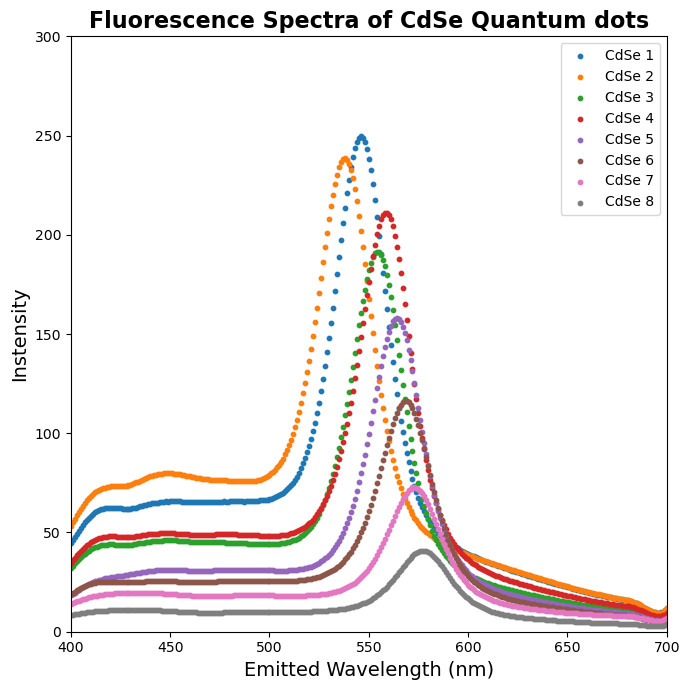

In [653]:
# Load all fluorescence file paths
Fluofiles = glob.glob('C:/CdSeData/ELJfl-*.txt')

# Initialize lists to store results from later analysis 
emitWavelen = [] # Emitted wavelength range
intensity = [] # Intensity of emitted wavelength
waveLenMaxInt = [] # Emitted wavelength of maximum intensity

# Extract full emitted wavelength range (x axis) and intensity (y-axis)
fluoData = cleanAndExtractData (Fluofiles, emitWavelen, 0, intensity, 1, "\t")

# Plot full Fluorescence data and extract the values of wavelength at maximum intensity
plt.figure(figsize=(7,7))

for i in range(len(Fluofiles)):
    plt.scatter(emitWavelen[i], intensity[i], label=f'CdSe {i+1}', s=10) 
    plt.legend()  
    waveLenMaxInt.append(emitWavelen[i][intensity[i].index(max(intensity[i]))])

plt.xlim(400,700)
plt.ylim(0,300)
plt.title("Fluorescence Spectra of CdSe Quantum dots", fontsize=16, fontweight='bold')
plt.xlabel("Emitted Wavelength (nm)", fontsize=14)
plt.ylabel("Instensity", fontsize=14)

plt.tight_layout()
plt.plot()

## III. UV-Vis Spectra Plot

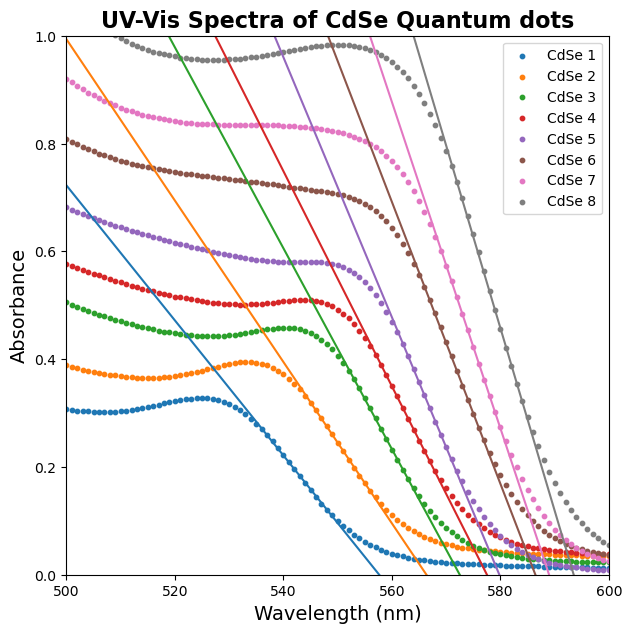

In [656]:
# Load all UV-Vis file paths
UVfiles =  glob.glob("C:/CdSeData/CdSe*.csv")

# Initialize lists to store results from later analysis
waveLen = [] # list to store full wavelength range
absorbance = [] # list to store full absorbance values
plotWaveLen = []  # list to store wavelength range that is necessary to visualize
plotAbsorbance = []  # list to store absorbance that is necessary to visualize
thresWaveLen = [] # threshold wavelength from UV-Vis data

# Extract full wavelength range (x axis) and absorbance values (y-axis)
uVisData = cleanAndExtractData (UVfiles, waveLen, 0, absorbance, 1, ",")

# Extract wavelength in 500-600 nm range (important parts) and corresponding absorbance values
for i in range(len(UVfiles)):
    wL = []
    aB = []
    for w, a in zip(waveLen[i], absorbance[i]):
        if w >= 500 and w <= 600:
            wL.append(w)
            aB.append(a)
    plotWaveLen.append(wL)
    plotAbsorbance.append(aB)

# Define startVal and endVal for each dataset (based on estimated linear range)
startEndVals = [(538, 550), (545, 557), (552, 562), (557, 567), (562, 570), (565, 575), (570, 580), (570, 583)]

# Plot UV-Vis Data (from 500 to 600 nm) and the linear fits on the same graph
plt.figure(figsize=(7, 7))

for i in range(len(UVfiles)):
    plt.scatter(plotWaveLen[i], plotAbsorbance[i], label=f'CdSe {i+1}', s=10)
    sVal, eVal = startEndVals[i] 
    thresholdWlen = linearFitAndPlot(plotWaveLen[i], plotAbsorbance[i], sVal, eVal)
    thresWaveLen.append(thresholdWlen)

plt.xlim(500, 600)
plt.ylim(0, 1)
plt.title("UV-Vis Spectra of CdSe Quantum dots", fontsize=16, fontweight='bold')
plt.xlabel("Wavelength (nm)", fontsize=14)
plt.ylabel("Absorbance", fontsize=14)

plt.legend()

## IV. Calculations of CdSe quantum dots' diameters

In [659]:
# Set up constant and list holder for radii calculations (both Fluorescence and UV-Vis)
enerGround = 1.751 * const.e # ground state energy (J), converted from 1.751 eV.
enerBulk = const.h * const.c / (709 * 1e-9) # energy of bulk materials (lamda_bulk = 709 nm)
m_h = 4.1 * 1e-31 # hole mass (kg)
corectFact = 10.62 
me = 0.13 # effective electron mass
mh = 0.45 # effective hole mass

### a. Fluorescence (Emission energy)
Emission energy can be calculated with known maximum emitted wavelength:

$$
E_{\text{emission}} = \frac{hc}{\lambda_{\text{max}}}
$$

The relationship between emission energy and ground state energy of quantum dots can be estimated as follows:

$$
E_{\text{emission}} = E_{\text{ground}} + \frac{h^2}{8r^2} \left( \frac{1}{m_e} + \frac{1}{m_h} \right) 
$$

Rearranging the above equation allows us to calculate the radius in the quadratic form with $x=\frac{1}{r}$

$$
\left( \frac{1}{r} \right)^2 \frac{h^2}{8} \left( \frac{1}{m_e} + \frac{1}{m_h} \right) + (E_{\text{ground}} - E_{\text{emission}}) = 0
$$]


In [662]:
# Lists to store FLuorescence data
enerExcitonList = [] # Exciton energy
diaFluoList = [] # CdSe diamaters list calculated from Fluorescence data

# Define constants in quadratic equation
a = (pow(const.h, 2)/8)*((1/const.m_e)+(1/m_h))

# Calculate exciton energy from transition energy and ground state energy
for w in waveLenMaxInt:
     enerTranst = const.h * const.c / (w * 1e-9)
     enerExcitonList.append(enerTranst - enerGround)

# Calculate diamaters based on Fluorescence data
for enerExciton in enerExcitonList:
    coefficients = [a, 0, - enerExciton] 
    dia = np.roots(coefficients)
    diaFluoList.append(round((1/dia[0])*1e9, 2))

### b. UV-Vis (Bandgap energy)

Energy gaps in bulk or nanomaterials can be calculated with known absorbance wavelength:

$$
E_g = \frac{hc}{\lambda_{\text{threshold}}} 
$$

The relationship between the energy gap of quantum dots and that of their bulk materials can be expressed as the Confinement Energy Equation as follows:

$$
E_g^{\text{nano}} = E_g^{\text{bulk}} + \frac{h^2}{8m_0r^2} \left( \frac{1}{m^*_e} + \frac{1}{m^*_h} \right) - \frac{1.8e^2}{4\pi \epsilon_0 \epsilon r} 
$$

Rearranging the above equation allows us to calculate the radius in the quadratic form with $x=\frac{1}{r}$

$$
\frac{h^2}{8m_0} \left( \frac{1}{m_e^*} + \frac{1}{m_h^*} \right) \left( \frac{1}{r} \right)^2 - \frac{1.8e^2}{4\pi \epsilon_0 \epsilon} \left( \frac{1}{r} \right) + \left( E_g^{\text{bulk}} - E_g^{\text{nano}} \right) = 0
$$
)}
$$


In [665]:
# Lists to store UV-Vis data
enerBGList = [] # energy of quantum-dots
diaUVisList = [] # CdSe radii list calculated from UV-Vis data

# Define constants in quadratic equation
a = (pow(const.h, 2)/8)*((1/me)+(1/mh))/(const.m_e)
b = -1.8*pow(const.e,2)/(4*const.pi*const.epsilon_0*corectFact)

# Calculate the difference of bandgap energy between bulk and nanomaterials
for w in thresWaveLen:
    enerNano = const.h * const.c / (w * 1e-9)
    enerBGList.append(enerNano - enerBulk)

# Calculate diamaters based on UV-Vis data
for eBG in enerBGList: 
    coefficients = [a, b, - eBG] 
    dia = np.roots(coefficients)
    diaUVisList.append(round((1/dia[0])*1e9, 2))

## V. Comparisons of Data from Fluorescence and UV-Vis 

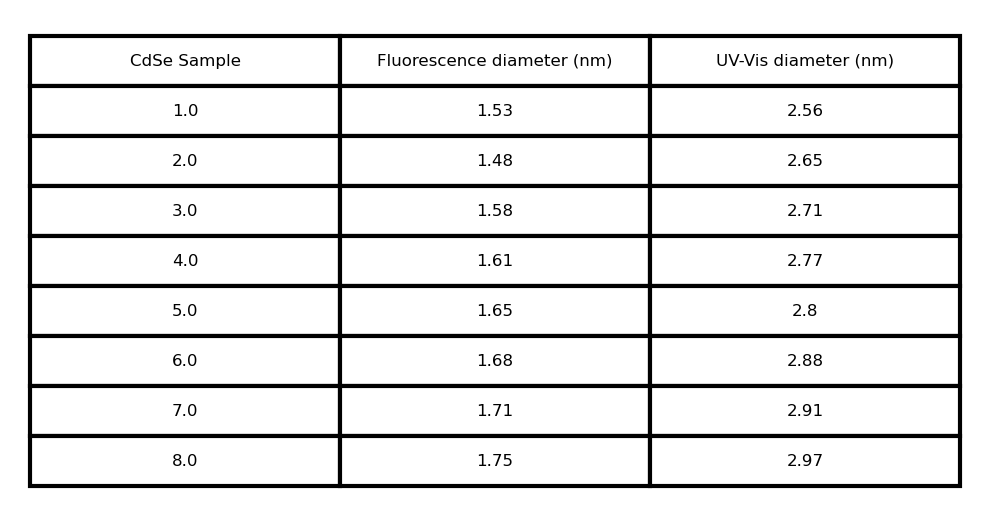

In [668]:
# Generate a comparison table for diamaters calculated by 2 approaches
dataSum = {"CdSe Sample": list(range(1,9)),
           "Fluorescence diameter (nm)": diaFluoList,
           "UV-Vis diameter (nm)": diaUVisList}      

df = pd.DataFrame(dataSum)

fig, ax = plt.subplots(figsize=(4, 2), dpi=300) 
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center') 

plt.show() 

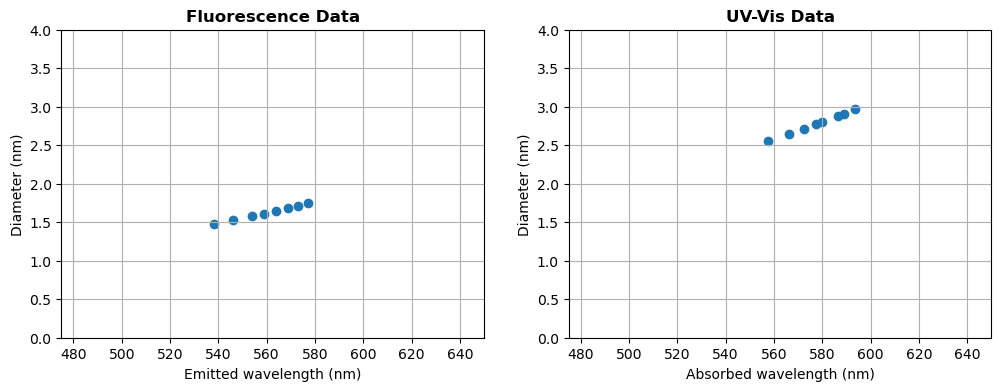

In [669]:
# Generate wavelength vs. radii plots for both approaches     
plt.figure(figsize=(12,4)) 
 
plt.subplot(1,2,1)
plt.scatter(waveLenMaxInt, diaFluoList)
plt.xlim(475,650)
plt.ylim(0,4)
plt.xlabel('Emitted wavelength (nm)')
plt.ylabel('Diameter (nm)')
plt.title('Fluorescence Data', fontweight='bold') 
plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(thresWaveLen, diaUVisList) 
plt.xlim(475,650)
plt.ylim(0,4)
plt.xlabel('Absorbed wavelength (nm)')
plt.ylabel('Diameter (nm)')
plt.title('UV-Vis Data', fontweight='bold') 
plt.grid(True)

## VI. Confinement Energy Equation: Diameter vs. Absorbed wavelength graph

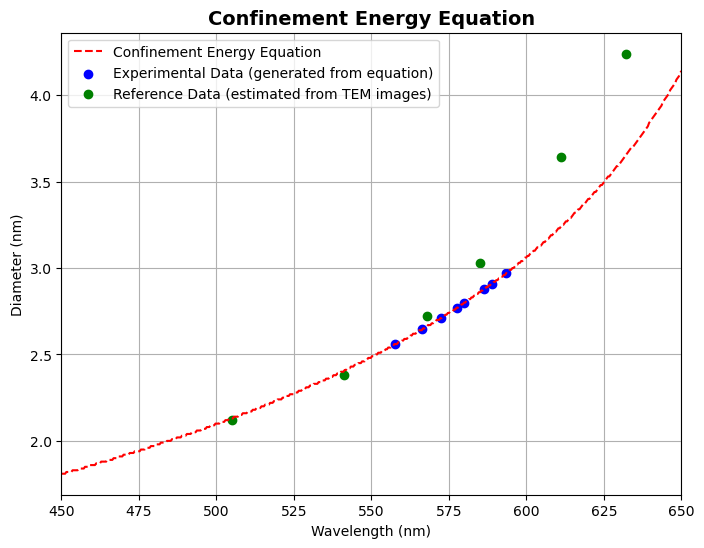

In [673]:
# Reference Data (slow growth)
refData = {
    "UV Emission (nm)": [505, 541, 568, 585, 611, 632],
    "T(C)": [110, 120, 150, 190, 220, 250],
    "t(min)": [40, 90, 150, 230, 330, 450],
    "dT/dt(C/min)": [0, 0.2, 0.5, 0.5, 0.3, 0.25],
    "d(nm)": [2.12, 2.38, 2.72, 3.03, 3.64, 4.24]
}

# Experimental Data (fast growth)
expData = {
    "UV Emission (nm)": thresWaveLen,
    "T(C)": [220, 220.3, 221.2, 223.9, 229.3, 238.3, 251.8, 270.7],
    "t(min)": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8],
    "dT/dt(C/min)": [3, 4.5, 9, 13.5, 18, 22.5, 27, 31.5],
}

# Fitting data for confinement energy equation
wavelengths = np.linspace(450, 650, 500) # wavelengths dataset
theoDiameter = [] # theoretical diamaters generated from Quantum confinement equation

for wl in wavelengths:
    d = UVabsorbanceQDsDiameter(me, mh, corectFact, enerBulk, wl)
    theoDiameter.append(round(1/d[0]*1e9, 2))
    
plt.figure(figsize=(8, 6))
plt.plot(wavelengths, theoDiameter, label="Confinement Energy Equation", color='r', linestyle='--')
plt.scatter(thresWaveLen, diaUVisList, label="Experimental Data (generated from equation)", color='b') 
plt.scatter(refData["UV Emission (nm)"], refData["d(nm)"], label="Reference Data (estimated from TEM images)", color='g') 
plt.xlim(450,650)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Diameter (nm)")
plt.title("Confinement Energy Equation", fontsize=14, fontweight="bold")
plt.legend()
plt.grid(True)
plt.show()

## VII. Generation of Mathematical Models

### Model 1: Linear Fit
This model represents the linear relationship between w and the sum of the temperature T and t * dT/dt, as shown:

$$
w = a \cdot \left(T + t \cdot \frac{dT}{dt}\right) + b
$$

#### Explanation:
- w was plotted against t and T, and proportional relationships for both graphs were observed.
- dT/dt was multiplied by t to cancel out the time unit.
- Linear fitting generated the highest R² value (Excel), so it was selected.

---

### Model 2: Quadratic Fit
This model represents the quadratic relationship between the reciprocal of w and the natural logarithm of t/T, as shown:

$$
\frac{1}{w} = a \cdot \left(\ln\left(\frac{t}{T}\right)\right)^2 + b \cdot \ln\left(\frac{t}{T}\right) + c
$$

#### Explanation:
- Natural logarithm fitting had the highest R² values when plotting w against t and T.
- The reciprocal of w was chosen instead of w because it better fit the quadratic equation for both experimental and reference datasets when plotted against the natural logarithm of t/T.

---

### Variables:
- **w**: UV absorbed wavelength in nm.  
- **T**: Instantaneous reaction temperature in °C.  
- **t**: Total reaction time in min.  
- **dT/dt**: Instantaneous temperature rising rate in °C/min.  

---

#### Note
The dataset for reaction time t and instantaneous temperature T were estimated for the experimental fast-growth procedure, while those for the reference data in the slow-growth process were measured. 

As a result, deviations from real experimental values might affect the quality of the fitting models.
fect the quality of the fitting models.
fect the quality of the fitting models.
ls.
ct the quality of the fitting models.
ct the quality of the fitting models.
$
$


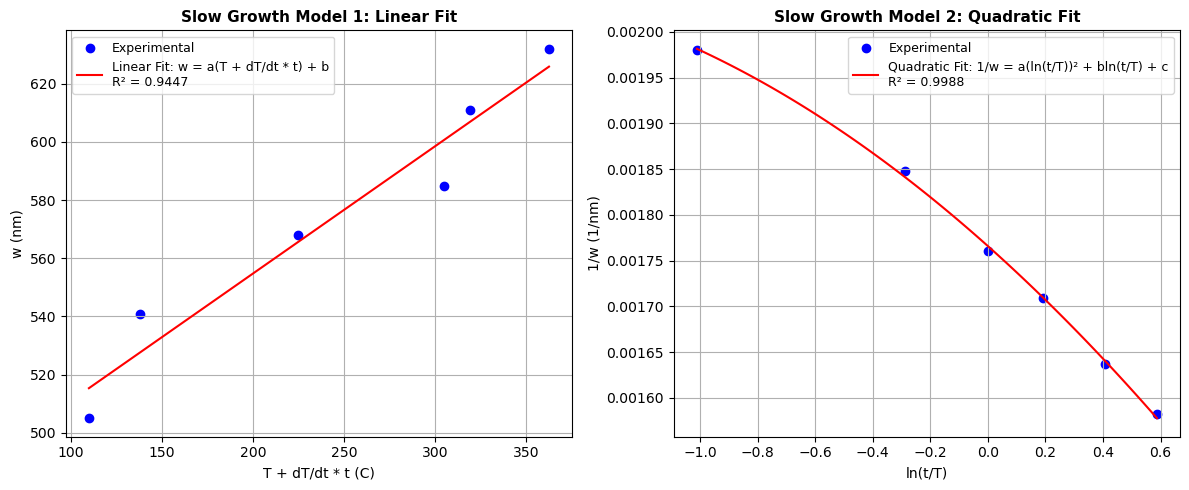

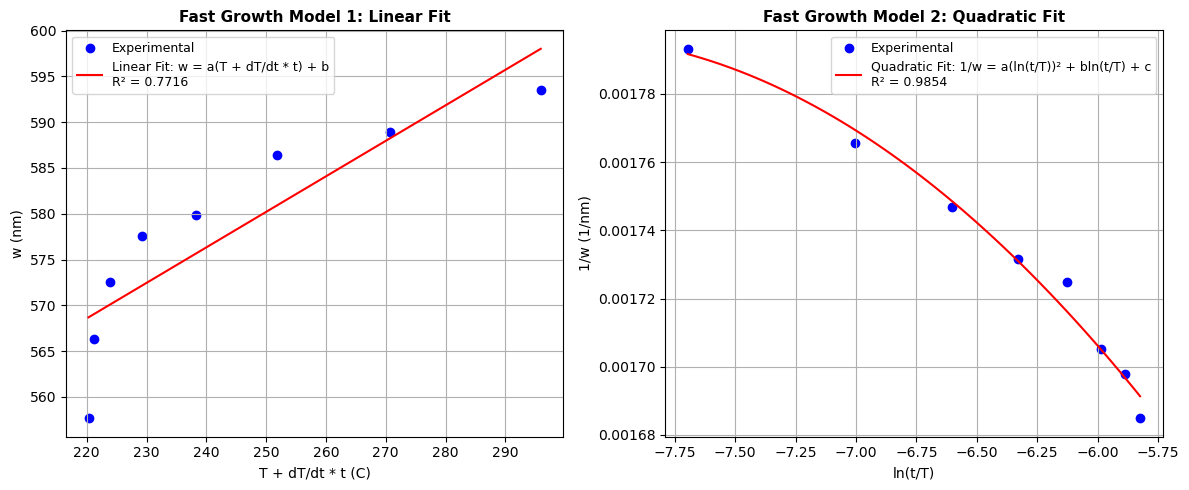

In [676]:
# Plot 2 models for both experimental and reference data
refPlots = analyzeQDsMathModels(refData, "Slow Growth")
expPlots = analyzeQDsMathModels(expData, "Fast Growth")

## VIII. Discussions
1. Both fluorescence and UV-Vis data display the proportional relationship between emission/absorbance wavelength and QDs' radius size. While both approaches simplify the the calculation of exciton energy by treating it as a particle in a box, and that ground state energy of CdSe QDs and energy gap of CdSe bulk materials are relatively close to each other, the particle sizes calculated by UV-Vis data are much higher. This is possibly caused by two reasons:

(1) Absoption wavelengths in UV-Vis are extrapolated threshold values, which can be higher than the actual threshold values. This means that diameters calculated from UV-Vis might be overestimated. 

(2) Column interaction is not involved in the fluorescence model: free mass (instead of effective mass) of electron and hole is used for calculation, which makes the its first coefficient (a) smaller. This means that diameters calculated from Fluorescence might be underestimated.

However, the fact that fluorescence model does not take Column interactions (including effective mass and binding energy) and its dependence on the chosen excited wavelength makes UV-Vis a more reliable approach to calculate quantum dots' size.

2. The Quantum confinement model underestimates the size of particles as absorbed UV wavelength gets higher, which contradicts the above statement
3. Quadratic model could help achieve desired QDs with diameter of less than 3 nm by adjusting reaction time and instantaneous temperature. Temperature rising rate seems not to have big impact on the absorbed wavelength based on this study as the quadratic fitting does not include this rate while still has high R-squared values for both dataset.
4. The data for reaction time and temperature were estimated for experimental data, meaning that the fast-growth data might be biased. More experimental data should be kept track of and different protocols for CdSe QDs synthesis could be conducted to validate the quality of the quadratic fitting model.


## Citation

(1) Zlateva, G.; Zhelev, Z.; Bakalova, R.; Kanno, I. Precise Size Control and Synchronized Synthesis of Six Colors of CdSe Quantum Dots in a Slow-Increasing Temperature Gradient. *Inorg. Chem.* **2007**, *46* (16), 6212–6214. [https://doi.org/10.1021/ic062045s](https://doi.org/10.1021/ic062045s)
)
